# Test to Ensure GPU Functional and Available

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from  IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn import datasets
import pandas as pd
import numpy as np
import datetime
import os
from matplotlib import pyplot as plt
import pathlib
import shutil
import tempfile

print(tf.__version__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2.1.0


__DD:__ Check to see if CUDA GPU is available:

In [2]:
tf.test.is_gpu_available(
    cuda_only=True, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

__DD:__ Try new function based on warnings:

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


__DD:__ I was wondering how to make sure GPU does the processing rather than CPU. I found the following excerpt from Tensorflow documentation:  

"If a TensorFlow operation has both CPU and GPU implementations, by default the GPU devices will be given priority when the operation is assigned to a device. For example, tf.matmul has both CPU and GPU kernels. On a system with devices CPU:0 and GPU:0, the GPU:0 device will be selected to run tf.matmul unless you explicitly request running it on another device."  

## Case Study 12

In [5]:

#os.getcwd()
#os.chdir('C:\\Users\\danie\\Documents\\GitHub\\Quantifying-The-World\\Case Study 6\\data')

__DD:__ To get the tensorflow docs packages working I had to clone the github repository to my local file system and run:  
_pip install -q C:\Users\danie\Documents\GitHub\docs_

In [6]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [7]:
#get data
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


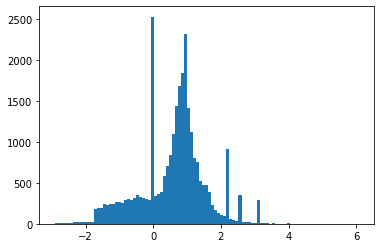

In [8]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

__DD:__ This is where we will tweek to mimic the article

In [9]:
#2.5 million train and 100000 validation as per article
#Batch suze = 1000 per article's Github



N_VALIDATION = int(10000)
N_TRAIN = int(250000)
BUFFER_SIZE = int(250000)
BATCH_SIZE = 10000
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

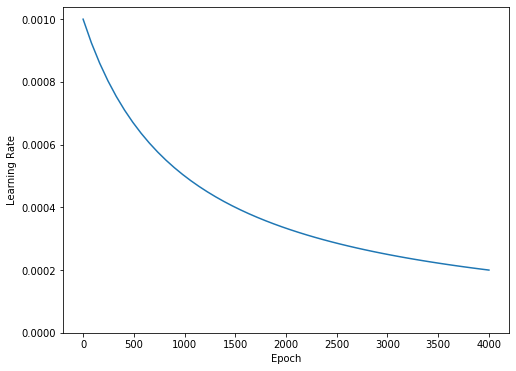

In [10]:
#The Dataset.skip and Dataset.take methods make this easy.
#At the same time, use the Dataset.cache method to ensure that the loader doesn't need to re-read
#the data form the file on each epoch:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

#These datasets return individual examples. Use the .batch 
#method to create batches of an appropriate size for training.
#Before batching also remember to .shuffle and .repeat the 
#training set.
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

#Many models train better if you gradually reduce the 
#learning rate during training. Use optimizers.schedules to
#reduce the learning rate over time:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

#The code above sets a schedules.InverseTimeDecay to 
#hyperbolically decrease the learning rate to 1/2 of the base
#rate at 1000 epochs, 1/3 at 2000 epochs and so on.
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply a . for each epoch and, and a full set of metrics every 100 epochs.

Next include callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.

Use callbacks.TensorBoard to generate TensorBoard logs for the training.

In [11]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [12]:
#Similarly each model will use the same Model.compile and 
#Model.fit settings:

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 189,601
Trainable params: 189,601
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5139,  binary_crossentropy:0.7191,  loss:0.7191,  val_accuracy:0.5580,  val_binary_crossentropy:0.6587,  val_loss:0.6587,  
....................................................................................................
E

(0.5, 0.7)

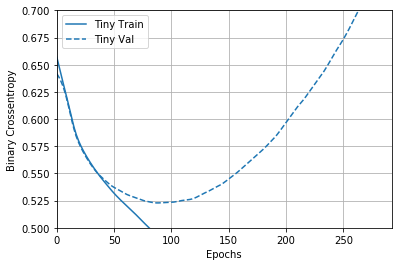

In [13]:
tiny_model = tf.keras.Sequential([
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
    layers.Dense(300, activation='tanh'),
    layers.Dense(300, activation='tanh'),
    layers.Dense(1)
])

size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [14]:
2500000

2500000